# Final experiment for Flower classification exploiting Hyperparameter optimization

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from keras.callbacks import EarlyStopping
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import numpy as np

### Load dataset from Drive

In [2]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/MyDrive/"
data_path = root_dir + "Colab Notebooks/Flowers/flowers/"

Mounted at /content/gdrive


### Creating train/val/test split

In [3]:
# Creating splits for dataset & Pre-process/Data augmentation
train_dataGen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True, preprocessing_function=preprocess_input)
train_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "train"), target_size=(224, 224), class_mode="categorical", shuffle=True, classes=[str(i) for i in range(0, 102)], batch_size=8, seed=42)

validation_dataGen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validation_generator = validation_dataGen.flow_from_directory(directory = os.path.join(data_path, "valid"), target_size=(224, 224), class_mode="categorical", classes=[str(i) for i in range(0, 102)], batch_size=8, seed=42)

test_generator = validation_dataGen.flow_from_directory(directory = os.path.join(data_path, "test"), target_size=(224, 224), class_mode="categorical", classes=[str(i) for i in range(0, 102)], batch_size=8, seed=42)

Found 1020 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.
Found 6149 images belonging to 102 classes.


In [4]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 5.3 MB/s 


### Definition for the best CNN architecture to search for

In [5]:
import keras_tuner as kt

def build_model(hp):
  # Build a DenseNet169 backbone
  densenet_FT = tf.keras.applications.densenet.DenseNet169(weights="imagenet", 
                                                           include_top=False,
                                                           input_shape=(224, 224, 3)
                                                           )
  densenet_FT.trainable = True
  # Choose from which dense block cut the model
  cutting_point = hp.Int('cutting_point', min_value=1, max_value=3, step=1, default=3)
  for layer in densenet_FT.layers:
    if cutting_point == 1:
      if 'conv5' in layer.name:
        layer.trainable = True
      else:
        layer.trainable = False
    elif cutting_point == 2:
      if 'conv5' in layer.name or 'conv4' in layer.name:
        layer.trainable = True
      else:
        layer.trainable = False
    elif cutting_point == 3:
      if 'conv5' in layer.name or 'conv4' in layer.name or 'conv3' in layer.name:
        layer.trainable = True
      else:
        layer.trainable = False

  model = keras.models.Sequential()
  model.add(densenet_FT)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.BatchNormalization())

  # Choose how many classifier
  num_classifier = hp.Int('num_classifier', min_value = 1, max_value = 3, step = 1 , default= 3)
  # Choose the activation function
  hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu'], default = 'relu')

  activation = keras.layers.LeakyReLU(alpha=0.01) if hp_activation == 'leaky-relu' else hp_activation

  # For each classifier choose how many neurons in the Dense layer and the probability for the Dropout regularization
  for i in range(num_classifier):
    hp_dense_size = hp.Choice(f'dense_size_{i}', values=[64, 128, 256], default=256)
    model.add(layers.Dense(hp_dense_size, activation=activation))

    hp_dropout_dense = hp.Choice(f'dropout_dense_{i}', values=[0.0, 0.2, 0.4], default=0.4)
    if hp_dropout_dense != 0: model.add(layers.Dropout(hp_dropout_dense))
  
  model.add(layers.Dense(102, activation="softmax"))

  # Choose the optimizer
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'], default = 'adam')
  optimizer = tf.keras.optimizers.get(hp_optimizer)
  # Choose the learning rate
  optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default = 1e-3)
                                      
  model.compile(optimizer=optimizer, 
                loss="categorical_crossentropy", 
                metrics = ["accuracy"])

  return model

### Bayesian optimization
We selected this optimization algorithm because in this way, leveraging the Bayes Theorem, we do not have to inspect all the search space.
**The proper computation was done locally because of the time taken by Colab from this step.**
All the necessary file were uploaded on Drive.

In [ ]:
tuner = kt.BayesianOptimization(build_model,
                                objective=kt.Objective('val_loss', direction="min"),
                                directory=data_path + 'keras_tuner',
                                max_trials = 25, overwrite=False,
                                project_name='tuned_model')

INFO:tensorflow:Reloading Oracle from existing project /content/gdrive/MyDrive/Colab Notebooks/Flowers/flowers/keras_tuner/tuned_model/oracle.json
51888128/51877672 [==============================] - 1s 0us/step
INFO:tensorflow:Reloading Tuner from /content/gdrive/MyDrive/Colab Notebooks/Flowers/flowers/keras_tuner/tuned_model/tuner0.json


In [ ]:
# The combination of all parameters
tuner.search_space_summary()

Search space summary
Default search space size: 11
cutting_point (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
num_classifier (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
dense_size_0 (Choice)
{'default': 256, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout_dense_0 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.0, 0.2, 0.4], 'ordered': True}
dense_size_1 (Choice)
{'default': 256, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout_dense_1 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.0, 0.2, 0.4], 'ordered': True}
dense_size_2 (Choice)
{'default': 256, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout_dense_2 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.0, 0.2, 0.4], 'ordered': True

*Here is the code for searching the best model with the best hyperparameters, **but because of the expensive computing time, it was done offline**.
The best model was uploaded in Drive.*

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, restore_best_weights=True,
                                   verbose=1)
callbacks = [early_stopping]
# Search best hyperparameter
tuner.search(train_generator, epochs=50, validation_data =validation_generator, 
             shuffle = True, callbacks=callbacks)

*Here, we load the best model uploaded on Drive.*

In [6]:
tuner = kt.BayesianOptimization(build_model,
                                objective=kt.Objective('val_loss', direction="min"),
                                directory=data_path + 'keras_tuner',
                                max_trials=1, overwrite=False,
                                project_name='tuned_model')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, restore_best_weights=True,
                               verbose=1)
callbacks = [early_stopping]
# Search best hyperparameter
tuner.search(train_generator, epochs=1, validation_data=validation_generator,
             shuffle=True, callbacks=callbacks)

INFO:tensorflow:Reloading Oracle from existing project /content/gdrive/MyDrive/Colab Notebooks/Flowers/flowers/keras_tuner/tuned_model/oracle.json
51888128/51877672 [==============================] - 0s 0us/step
INFO:tensorflow:Reloading Tuner from /content/gdrive/MyDrive/Colab Notebooks/Flowers/flowers/keras_tuner/tuned_model/tuner0.json
INFO:tensorflow:Oracle triggered exit


### Showing the best hyperparameters

In [7]:
# Get the best hyperparameters obtained
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'activation': 'relu',
 'cutting_point': 3,
 'dense_size_0': 256,
 'dense_size_1': 256,
 'dense_size_2': 256,
 'dropout_dense_0': 0.4,
 'dropout_dense_1': 0.4,
 'dropout_dense_2': 0.0,
 'learning_rate': 0.0001,
 'num_classifier': 1,
 'optimizer': 'adam'}

In [8]:
# Loading the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               2

In [ ]:
best_model.save(data_path + 'tuned_model/' + 'best_hyperparameter_tuned_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Flowers/flowers/tuned_model/best_hyperparameter_tuned_model/assets


The tuner returns a model already trained on the best parameters, however even if it is usually good to re-train from scratch by building a new model, in this case we should have avoided it since retraining is usually done as the tuning is made on a subset of the training set, but in this case.
We are re-training just for the purpose of extracting useful information about it.

In [9]:
tuned_model = tuner.hypermodel.build(best_hps)

history = tuned_model.fit(train_generator,
                          epochs=50, callbacks=callbacks, 
                          validation_data=validation_generator,
                          )

Epoch 1/50
128/128 [==============================] - 562s 4s/step - loss: 4.7136 - accuracy: 0.0402 - val_loss: 4.7157 - val_accuracy: 0.0235
Epoch 2/50
128/128 [==============================] - 30s 234ms/step - loss: 3.7935 - accuracy: 0.1598 - val_loss: 4.5366 - val_accuracy: 0.0618
Epoch 3/50
128/128 [==============================] - 30s 234ms/step - loss: 2.9518 - accuracy: 0.3098 - val_loss: 3.8758 - val_accuracy: 0.1598
Epoch 4/50
128/128 [==============================] - 30s 235ms/step - loss: 2.2757 - accuracy: 0.5010 - val_loss: 2.8314 - val_accuracy: 0.3627
Epoch 5/50
128/128 [==============================] - 30s 235ms/step - loss: 1.8148 - accuracy: 0.6284 - val_loss: 1.9913 - val_accuracy: 0.5363
Epoch 6/50
128/128 [==============================] - 30s 235ms/step - loss: 1.4006 - accuracy: 0.7078 - val_loss: 1.5862 - val_accuracy: 0.6333
Epoch 7/50
128/128 [==============================] - 30s 235ms/step - loss: 1.0363 - accuracy: 0.7922 - val_loss: 1.2524 - val_accu

In [10]:
tuned_model.save(data_path + 'tuned_model/' + 'best_hyperparameter_tuned_model_retrained')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Flowers/flowers/tuned_model/best_hyperparameter_tuned_model_retrained/assets


### Evaluate the model on the validation set

In [11]:
score = tuned_model.evaluate(validation_generator)
print(f"Val Loss: {score[0]}")
print(f"Val Accuracy: {score[1]}")

128/128 [==============================] - 11s 84ms/step - loss: 0.8318 - accuracy: 0.7755
Val Loss: 0.8318096995353699
Val Accuracy: 0.7754902243614197


In [12]:
print(f"Train accuracy: {np.max(history.history['accuracy'])}")
print(f"Validation accuracy: {np.max(history.history['val_accuracy'])}")
print(f"Train loss: {np.max(history.history['loss'])}")
print(f"Validation loss: {np.max(history.history['val_loss'])}")

Train accuracy: 0.9813725352287292
Validation accuracy: 0.7862744927406311
Train loss: 4.713596820831299
Validation loss: 4.715669631958008


### Plotting train/validation loss and accuracy and evaluate the model on unseen data, the test set.

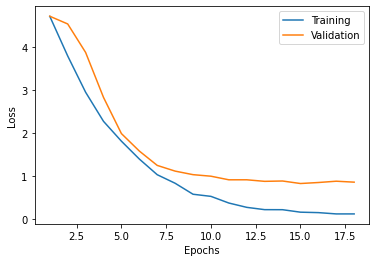

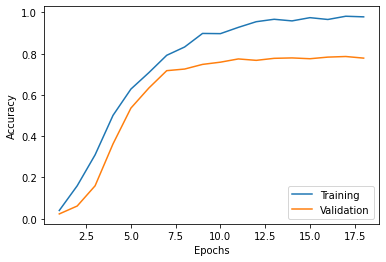

769/769 [==============================] - 1576s 2s/step - loss: 1.0277 - accuracy: 0.7494
Test Loss: 1.0277196168899536
Test Accuracy: 0.7493901252746582


In [13]:
x_plot = list(range(1, len(history.history['val_accuracy']) + 1))
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, history.history['loss'])
plt.plot(x_plot, history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, history.history['accuracy'])
plt.plot(x_plot, history.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

score = tuned_model.evaluate(test_generator)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# See the optimized model in action
We show how the model predict new unseen data.
The images in the picture below are viewed like that because of the preprocessing made before.
If a missclassification occurs, in bold, we show the correct label.

In [ ]:
tuned_model = keras.models.load_model(data_path + 'tuned_model/' + 'best_hyperparameter_tuned_model_retrained')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predictions:
 [40 88 95 54 78 51 78 80]
Labels:
 [40 88 95 54 36 51 50 80]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


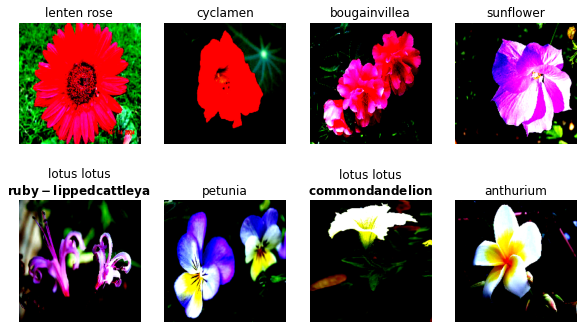

In [ ]:
import json
names_path = os.path.join(data_path, 'label_to_names.json')
with open(names_path, mode='r') as file:
  image_names = json.load(file)

# Retrieve a batch of images from the test set
image_batch, label_batch = next(test_generator)
predictions = tuned_model.predict_on_batch(image_batch)

predictions = np.argmax(predictions, axis=1)
label_batch = np.argmax(label_batch, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 6))
for i in range(8):
  ax = plt.subplot(2, 4, i + 1)
  plt.imshow(image_batch[i]*255)
  if not predictions[i] == label_batch[i]:
    # In bold there is the correct label
    plt.title(image_names[str(predictions[i])] + "\n" + r"$\bf{" + image_names[str(label_batch[i])] + "}$")
  else:
    plt.title(image_names[str(predictions[i])])
  plt.axis("off")